# Analysing flight delays data

The flight-delays and cancellation data was collected and published by the U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics. This data records the flights operated by large air carriers and tracks the on-time performance of domestic flights. This data summarises various flight information such as the number of on-time, delayed, cancelled, and diverted flights published in DOT's monthly in 2015.

The complete dataset also can be downloaded publicly from [here](https://www.kaggle.com/usdot/flight-delays).

# Table of contents<a class="anchor" id="table"></a>

### [**1. Data Loading, Cleaning, Labelling, and Exploration**](#1)
* [**1.1 Data loading**](#1.1)
 * [1.1.1 Create SparkSession and SparkContext](#1.1.1)
 * [1.1.2 Import CSV files into single DataFrame](#1.1.2)
 * [1.1.3 Obtain list of columns](#1.1.3)
* [**1.2 Data cleaning**](#1.2)
 * [1.2.1 Check for missing values](#1.2.1)
 * [1.2.2 Removing rows/columns](#1.2.2)
   * [a. Obtain column names with high percentage of missing values](#1.2.2a.)
   * [b. Eliminate columns based on removedColumns](#1.2.2b.)
   * [c. Eliminate rows with NaNs or Nulls](#1.2.2c.)
* [**1.3 Data Labelling**](#1.3)
 * [1.3.1 Manual labelling](#1.3.1)
   * [a. Binary labels](#1.3.1a.)
   * [b. Multiclass labels](#1.3.1b.)
 * [1.3.2 Auto labelling](#1.3.2)
* [**1.4 Data exploration / exploratory analysis**](#1.4)
 * [1.4.1 Basic statistics](#1.4.1)
 * [1.4.2 Categorical columns](#1.4.2)
 * [1.4.3 Histograms / bar charts](#1.4.3)
   * [a. Late arrivals by month](#1.4.3a.)
   * [b. Late arrivals by day](#1.4.3b.)
   * [c. Late departures by airline](#1.4.3c.)<br>
   
###  [**2. Feature extraction and ML training**](#2)
* [**2.1 Feature selection**](#2.1)
 * [2.1.2 Create analytical dataset](#2.1.2)
* [**2.2 Preparing transformers and estimators**](#2.2)
 * [2.2.1 Transformers](#2.2.1)
 * [2.2.2 Transformer to map months to seasons](#2.2.2)
 * [2.2.3 Binary Decision Tree and Gradient Boosted Tree](#2.2.3)
 * [2.2.4 Multiclass Naive Bayes](#2.2.4)
 * [2.2.5 Pipelines](#2.2.5)
* [**2.3 Training and testing split**](#2.3)
* [**2.4 Training and evaluating models**](#2.4)
 * [2.4.1 Binary classification](#2.4.1)
   * [a. Train binary class models](#2.4.1a.)
   * [b. Model transformations and confusion matrices](#2.4.1b.)
   * [c. Compute binary metrics](#2.4.1c.)
   * [d. Discussion of binary metrics](#2.4.1d.)
   * [e. Discussion of binary models](#2.4.1e.)
   * [f. Splitting criteria and top features](#2.4.1f.)
   * [g. Binary model improvement discussion](#2.4.1g.)
 * [2.4.2 Multiclass classification](#2.4.2)
   * [a. Train multiclass model](#2.4.2a.)
   * [b. Multiclass model transformation and confusion matrix](#2.4.2b.)
   * [c. Compute multiclass metrics](#2.4.2c.)
   * [d. Discussion of multiclass metrics](#2.4.2d.)
   * [e. Naive Bayes model improvement discussion](#2.4.2e.)

# 1. Data Loading, Cleaning, Labelling, and Exploration<a class="anchor" id="1"></a>
## 1.1 Data loading<a class="anchor" id="1.1"></a>
### 1.1.1 Create SparkSession and SparkContext<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

In [1]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Create Spark Configuration Object with 2 processors
spark_conf = SparkConf().setMaster('local[*]').setAppName('Analysing Flight-delays Data')

# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

### 1.1.2 Import CSV files into single DataFrame<a class="anchor" id="1.1.2"></a>
[Back to top](#table)

In [2]:
# Read csv files into a dataframes (from data subfolder)
flightsRawDf = spark.read.csv('data/flight*.csv', header = True, inferSchema = True)

In [3]:
# Display total number of rows
flightsRawDf.count()

582184

### 1.1.3 Obtain list of columns<a class="anchor" id="1.1.3"></a>
[Back to top](#table)

In [4]:
# Create list of column headings of flightsRawDf
allColumnFlights = flightsRawDf.columns
allColumnFlights

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

## 1.2 Data cleaning<a class="anchor" id="1.2"></a>
### 1.2.1 Check for missing values<a class="anchor" id="1.2.1"></a>
[Back to top](#table)

In [5]:
# Check for Nulls and NaNs
from pyspark.sql.functions import isnan, when, count, col
missingValues = flightsRawDf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in allColumnFlights])
missingValues.toPandas().head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,0,0,0,0,1462,0,0,0,...,9257,10455,0,0,573213,475831,475831,475831,475831,475831


In [6]:
# Check for Nulls and NaNs as %
missing = flightsRawDf.select([(100*count(when(isnan(c) | col(c).isNull(), c))/flightsRawDf \
                                .count()).alias(c) for c in allColumnFlights])

missing_list = list(missing.first())

# Show percentage of missing values for all non-zero columns
for i in range(len(allColumnFlights)):
    if missing_list[i]:
        print(allColumnFlights[i] + ": " + str(round(missing_list[i], 2)) + "%")

TAIL_NUMBER: 0.25%
DEPARTURE_TIME: 1.48%
DEPARTURE_DELAY: 1.48%
TAXI_OUT: 1.53%
WHEELS_OFF: 1.53%
SCHEDULED_TIME: 0.0%
ELAPSED_TIME: 1.8%
AIR_TIME: 1.8%
WHEELS_ON: 1.59%
TAXI_IN: 1.59%
ARRIVAL_TIME: 1.59%
ARRIVAL_DELAY: 1.8%
CANCELLATION_REASON: 98.46%
AIR_SYSTEM_DELAY: 81.73%
SECURITY_DELAY: 81.73%
AIRLINE_DELAY: 81.73%
LATE_AIRCRAFT_DELAY: 81.73%
WEATHER_DELAY: 81.73%


AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY and WEATHER_DELAY all have the exact same number of missing values / percentage of missing values at 81.73%, which means they are not missing at random. CANCELLATION_REASON has the highest amount of missing values at almost 98.5%. Other columns that share the same amount of missing values:
* DEPARTURE_TIME and DEPARTURE_DELAY
* TAXI_OUT and WHEELS_OFF (which have slightly greater missingness than DEPARTURE_TIME and DEPARTURE_DELAY)
* ELAPSED_TIME and AIR_TIME
* WHEELS_ON, TAXI_IN and ARRIVAL_TIME

### 1.2.2 Removing rows/columns<a class="anchor" id="1.2.2"></a>
#### 1.2.2 a. Obtain column names with high percentage of missing values<a class="anchor" id="1.2.2a."></a>
[Back to top](#table)

In [7]:
# x is the threshold value which defines percentage of missing values from the entire rows of flightsRawDf

x = 10

def find_removed_columns(x, flightsRawDf):
    
    # Get list of column names
    columnNames = flightsRawDf.columns
    
    # Get percentage of missing values for each column
    missingPercent = flightsRawDf.select([(100*count(when(isnan(c) | col(c).isNull(), c))/flightsRawDf \
                                .count()).alias(c) for c in flightsRawDf.columns])
    
    # Add columns to removedColumns list if missing values percent greater than x threshold
    removedColumns = [col for col, percent in zip(flightsRawDf.columns, list(missingPercent.first())) if percent > x]
    
    return removedColumns

removedColumns = find_removed_columns(x, flightsRawDf)
removedColumns

['CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

#### 1.2.2 b. Eliminate columns based on removedColumns<a class="anchor" id="1.2.2b."></a>
[Back to top](#table)

In [8]:
def eliminate_columns(removedColumns, flightsRawDf):
    
    return flightsRawDf.drop(*removedColumns)

flightsRawDf = eliminate_columns(removedColumns, flightsRawDf)

In [9]:
print("Number of rows: " + str(flightsRawDf.count()))
print("Number of columns: " + str(len(flightsRawDf.columns)))

Number of rows: 582184
Number of columns: 25


#### 1.2.2 c. Eliminate rows with NaNs or Nulls<a class="anchor" id="1.2.2c."></a>
[Back to top](#table)

In [10]:
# Drop rows with missing values
flightsDf = flightsRawDf.dropna() 

In [11]:
print("Number of rows: " + str(flightsDf.count()))
print("Number of columns: " + str(len(flightsDf.columns)))

Number of rows: 571729
Number of columns: 25


## 1.3 Data Labelling<a class="anchor" id="1.3"></a>
### 1.3.1 Manual labelling<a class="anchor" id="1.3.1"></a>
#### 1.3.1 a. Binary labels<a class="anchor" id="1.3.1a."></a>
[Back to top](#table)

Using approach found [here](https://stackoverflow.com/questions/51565395/pyspark-create-new-column-and-fill-in-based-on-conditions-of-two-other-columns):

In [12]:
import pyspark.sql.functions as F

# Add new column: 1 when ARRIVAL_DELAY is greater than 0 (late), otherwise 0
flightsDf = flightsDf.withColumn('binaryArrDelay', F.when((F.col('ARRIVAL_DELAY') > 0), 1 ).otherwise(0))

# Add new column: 1 when DEPARTURE_DELAY is greater than 0 (late), otherwise 0
flightsDf = flightsDf.withColumn('binaryDeptDelay', F.when((F.col('DEPARTURE_DELAY') > 0), 1 ).otherwise(0))

#### 1.3.1 b. Multiclass labels<a class="anchor" id="1.3.1b."></a>
[Back to top](#table)

In [13]:
# Add new column: 0, 1, 2 for early, on time and late re ARRIVAL_DELAY
flightsDf = flightsDf.withColumn('multiClassArrDelay',\
                                 F.when((F.col('ARRIVAL_DELAY') < 5), 0)\
                                .when((F.col('ARRIVAL_DELAY') <= 20), 1)\
                                .otherwise(2))

# Add new column: 0, 1, 2 for early, on time and late re DEPARTURE_DELAY
flightsDf = flightsDf.withColumn('multiClassDeptDelay',\
                                 F.when((F.col('DEPARTURE_DELAY') < 5), 0)\
                                .when((F.col('DEPARTURE_DELAY') <= 20), 1)\
                                .otherwise(2))

### 1.3.2 Auto labelling<a class="anchor" id="1.3.2"></a>
[Back to top](#table)

In [14]:
# Create list of raw delay column names
cols = ['ARRIVAL_DELAY', 'DEPARTURE_DELAY']

# View distribution of data
flightsDf.select(cols).toPandas().describe(percentiles = [.25,.33,.67,.75])

,ARRIVAL_DELAY,DEPARTURE_DELAY
count,571729.000000,571729.000000
mean,4.467085,9.323501
std,39.787086,37.430095
min,-82.000000,-48.000000
25%,-13.000000,-5.000000
33%,-10.000000,-4.000000
50%,-5.000000,-2.000000
67%,2.000000,2.000000
75%,8.000000,7.000000
max,1665.000000,1670.000000


In [15]:
# Multi-class data labelling function
def multi_class_labels(df, inputColumns, outputColumns, lowerPercentile, upperPercentile):
    
    # Get values based on chosen percentiles
    stats = df.select(inputColumns).toPandas().describe(percentiles = [lowerPercentile, upperPercentile])
    
    # reassign so variable name different to function parameter name
    dfLabelled = df
    
    # For each column input
    for i in range(len(inputColumns)):
        
        # Get cutoff values based on percentiles
        lowerBreak = stats.loc[str(int(lowerPercentile*100)) + ('%')][i]
        upperBreak = stats.loc[str(int(upperPercentile*100)) + ('%')][i]
        
        # Create new column from values of existing column and break points
        dfLabelled = dfLabelled.withColumn(outputColumns[i],\
                              F.when((F.col(inputColumns[i]) <= lowerBreak), 0)\
                              .when((F.col(inputColumns[i]) <= upperBreak), 1)\
                              .otherwise(2))
        
    return dfLabelled

In [16]:
# Create list of output column names
outputCols = ['multiClassArrDelay', 'multiClassDeptDelay']

# Apply function to alter multi class delay columns
flightsDf = multi_class_labels(flightsDf, cols, outputCols, .33, .67)

From the statistics above, even size bins based on min and max values would not be very representative of the data as it would leave very few 'late' class labels and a significant number of 'early' class labels based on the positive skew of the datasets. We suspect the data is skewed as the medians are -5 and -2 while the means are 4.5 and 9.3 respectively with much larger magnitude maximums than minimums, meaning a few large positive values are 'pulling' the mean up even though a large number of values are negative or small positive.

The choice of bins allows for an even distribution of labels so that the dataset is balanced for these labels. Based on the above data, "early" actually means more than **x** minutes early, 'on time' means between **x** minutes early and **y** minutes late and 'late' means more than **y** minutes late, where **x** and **y** are specific to each delay type.

## 1.4 Data exploration / exploratory analysis<a class="anchor" id="1.4"></a>
### 1.4.1 Basic statistics<a class="anchor" id="1.4.1"></a>
[Back to top](#table)

In [17]:
import pandas as pd

# Allow all columns to be displayed
with pd.option_context('display.max_columns', len(flightsDf.columns)):
     print(flightsDf.select('*').toPandas().describe()) # Use pandas to display statistics

           YEAR          MONTH            DAY    DAY_OF_WEEK  FLIGHT_NUMBER  \
count  571729.0  571729.000000  571729.000000  571729.000000  571729.000000   
mean     2015.0       6.542260      15.711267       3.932858    2160.621280   
std         0.0       3.398908       8.768838       1.984087    1752.191061   
min      2015.0       1.000000       1.000000       1.000000       1.000000   
25%      2015.0       4.000000       8.000000       2.000000     727.000000   
50%      2015.0       7.000000      16.000000       4.000000    1678.000000   
75%      2015.0       9.000000      23.000000       6.000000    3202.000000   
max      2015.0      12.000000      31.000000       7.000000    7438.000000   

       SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY       TAXI_OUT  \
count        571729.000000   571729.000000    571729.000000  571729.000000   
mean           1328.704886     1334.714510         9.323501      16.076809   
std             483.322122      496.152643        37.4

The means of columns YEAR, MONTH, DAY and DAY_OF_WEEK do not provide much semantic meaning and will need to be indexed if they are to be used in modelling. The means of columns that are a 24 hour time provide an average time but this is not particularly useful either. FLIGHT_NUMBER is rather arbitrary, so the mean flight number of 2,160 is not useful to us. DIVERTED and CANCELLED are more like string indexed categorical variables and since they are all 0, the means are 0. For other feature columns the means represent average time, except for distance, which is the number of miles between origin and destination airports. The summary statistics for the below table suggest positive skew based on the given quartiles.

Feature|Metadata description|Mean
:-----------|:-----------|:-----------
DEPARTURE_DELAY|Average delay on departure|9.32 min
TAXI_OUT|The average time duration elapsed between departure from the origin airport gate and wheels off|16.07 min
TAXI_IN|The average time duration elapsed between wheels-on and gate arrival at the destination airport|7.43 min
ELAPSED_TIME|Average AIR_TIME+TAXI_IN+TAXI_OUT|137.03 min
AIR_TIME|The average time duration between wheels off and wheels on time|113.52 min
DISTANCE|Average distance between two airports|824.30 miles
ARRIVAL_DELAY|Average delay of arrival (ARRIVAL_TIME - SCHEDULED_ARRIVAL)|4.47 min

### 1.4.2 Categorical columns<a class="anchor" id="1.4.2"></a>
[Back to top](#table)

In [18]:
# Show descriptive statistics of qualitative columns
flightsDf.select('*').toPandas().describe(include=['O'])

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
count,571729,571729,571729,571729
unique,14,4802,625,624
top,WN,N480HA,ATL,ATL
freq,123912,398,34506,34087


The above analysis shows the total unique categories (**unique**) as well as the category name (**top**) and frequency (**freq**) of the highest occuring category for each categorical column. Southwest Airlines (WN) is the most common airline, accounting for over 20% of flights while Atlanta (ATL) has the most common airport.

### 1.4.3 Histograms / bar charts<a class="anchor" id="1.4.3"></a>
[Back to top](#table)

In [19]:
# Create table that can be queried
flightsDf.createOrReplaceTempView("flightsDf_sql")

#### 1.4.3 a. Late arrivals by month<a class="anchor" id="1.4.3a."></a>
[Back to top](#table)

In [20]:
lateFlightsByMonth = spark.sql('''
    SELECT MONTH, 
            ROUND(100*COUNT(NULLIF(0, binaryArrDelay))/COUNT(*), 2) as PERCENTAGE
    FROM flightsDf_sql
    GROUP BY MONTH
    ORDER BY MONTH
''')

Text(0, 0.5, '%')

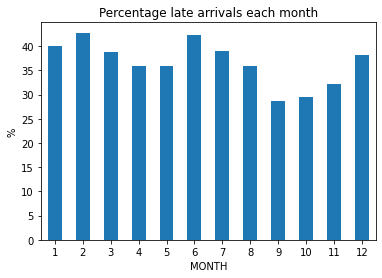

In [21]:
# Plot output
lateFlightsByMonth.toPandas().plot(
    kind='bar',
    x='MONTH',
    y='PERCENTAGE',
    rot=0,
    legend=False,
    title='Percentage late arrivals each month')\
    .set_ylabel('%')

Autumn (fall) in the U.S has a lower rate of late arrivals compared to other seasons.

#### 1.4.3 b. Late arrivals by day<a class="anchor" id="1.4.3b."></a>
[Back to top](#table)

In [22]:
lateFlightsByDay = spark.sql('''
    SELECT DAY_OF_WEEK, 
            ROUND(100*COUNT(NULLIF(0, binaryArrDelay))/COUNT(*), 2) as PERCENTAGE
    FROM flightsDf_sql
    GROUP BY DAY_OF_WEEK
    ORDER BY DAY_OF_WEEK
''')
test = lateFlightsByDay.toPandas()

Text(0, 0.5, '%')

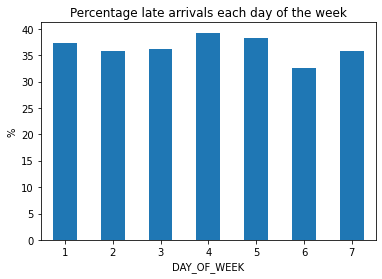

In [23]:
# Plot output
lateFlightsByDay.toPandas().plot(
    kind='bar',
    x='DAY_OF_WEEK',
    y='PERCENTAGE',
    rot=0,
    legend=False,
    title='Percentage late arrivals each day of the week')\
    .set_ylabel('%')

#### 1.4.3 c. Late departures by airline<a class="anchor" id="1.4.3c."></a>
[Back to top](#table)

Using [this](https://stackoverflow.com/questions/770579/how-to-calculate-percentage-with-a-sql-statement/37403456) method to get percentages.

In [24]:
lateFlightsByAirline = spark.sql('''
    SELECT AIRLINE, count(*) * 100 / sum(count(*)) over() as PERCENTAGE
    FROM flightsDF_sql
    WHERE binaryDeptDelay = 1
    GROUP BY AIRLINE
''')

Text(0, 0.5, '%')

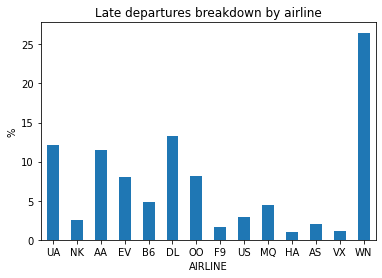

In [25]:
# Plot output
lateFlightsByAirline.toPandas().plot(
    kind='bar',
    x='AIRLINE',
    y='PERCENTAGE',
    rot=0,
    legend=False,
    title='Late departures breakdown by airline')\
    .set_ylabel('%')

# 2. Feature extraction and ML training<a class="anchor" id="2"></a>
## 2.1 Feature selection<a class="anchor" id="2.1"></a>
[Back to top](#table)

In [26]:
# Display correlation matrix
pd.options.display.max_columns = 30
flightsDf.toPandas().corr().dropna(axis=0,how='all').dropna(axis=1,how='all')

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiClassDeptDelay
MONTH,1.000000,0.004354,-0.011835,-0.020922,-0.000739,-0.005156,-0.021136,-0.012162,-0.005567,0.009833,0.001209,0.002682,0.010167,-0.010184,0.000831,-0.011723,-0.010672,-0.036217,-0.053875,-0.037683,-0.058077,-0.029714
DAY,0.004354,1.000000,0.001057,0.000132,-0.001213,-0.002348,-0.001327,-0.002073,-0.003012,0.003074,0.001710,0.002066,0.003293,-0.002780,-0.000672,-0.001633,-0.002120,-0.003873,-0.006956,-0.003501,-0.006552,-0.002937
DAY_OF_WEEK,-0.011835,0.001057,1.000000,0.014270,0.006439,0.004540,-0.009496,-0.022014,0.002679,0.015879,0.012699,0.015607,0.017207,0.004201,0.002166,0.005400,0.003631,-0.015288,-0.011677,-0.001282,-0.016838,-0.001485
FLIGHT_NUMBER,-0.020922,0.000132,0.014270,1.000000,-0.004104,0.001425,-0.008599,0.049131,0.008011,-0.315371,-0.305986,-0.318995,-0.329182,-0.004609,-0.020246,-0.013307,-0.001136,0.017929,0.013503,-0.052005,0.018258,-0.068283
SCHEDULED_DEPARTURE,-0.000739,-0.001213,0.006439,-0.004104,1.000000,0.963318,0.108216,0.006438,0.938467,-0.019202,-0.021204,-0.018974,-0.012057,0.661917,-0.046524,0.709157,0.634908,0.098594,0.125526,0.186498,0.120633,0.176446
DEPARTURE_TIME,-0.005156,-0.002348,0.004540,0.001425,0.963318,1.000000,0.166282,0.013999,0.972847,-0.023988,-0.025175,-0.024353,-0.019487,0.682338,-0.041851,0.714185,0.654593,0.154869,0.159455,0.224339,0.153600,0.214798
DEPARTURE_DELAY,-0.021136,-0.001327,-0.009496,-0.008599,0.108216,0.166282,1.000000,0.058651,0.158186,0.027801,0.030980,0.023384,0.024531,0.058625,0.015464,0.096108,0.049747,0.945931,0.426323,0.477504,0.412188,0.475528
TAXI_OUT,-0.012162,-0.002073,-0.022014,0.049131,0.006438,0.013999,0.058651,1.000000,0.039321,0.114383,0.208094,0.089963,0.074333,0.034209,0.002702,0.025135,0.031775,0.226676,0.277381,0.052396,0.284171,0.054689
WHEELS_OFF,-0.005567,-0.003012,0.002679,0.008011,0.938467,0.972847,0.158186,0.039321,1.000000,-0.031549,-0.030390,-0.032987,-0.030807,0.701473,-0.040035,0.725603,0.673536,0.151829,0.162454,0.220059,0.157104,0.210788
SCHEDULED_TIME,0.009833,0.003074,0.015879,-0.315371,-0.019202,-0.023988,0.027801,0.114383,-0.031549,1.000000,0.985162,0.990730,0.984416,0.022978,0.098618,0.031135,0.020505,-0.028549,-0.008962,0.067518,-0.056437,0.077553


Pearson's correlation cannot be used for categorical variables as it mentions how two variables move together, which does not work for variables with no logical order. The $\chi^2$ test could be used to see if two categorical variables are related. Alternatively, Cramer's V can also be used to calculate correlation for categorical features.

Feature|Discussion|
:-----------|:-----------|
YEAR| Not useful as a feature column as the dataset relates to the 2015 year only, so the value for every row is the same. For tree based models there would be no information gain in splitting on this criterion.
MONTH| The plot above showed that different months had different proportions of late and not late flights so this could be a useful feature.
DAY| Seems unlikely that the day of the month would have an impact on predicting delays and the correlation with labels is more or less zero.
DAY_OF_WEEK| The plot above showed some differences in percentage of late arrival for each day of the week (although less so than for MONTH. Nonetheless it could still provide some explanatory power.
AIRLINE| The plot above showed an interesting breakdown of late departures by airline so it is worth including as a feature.
FLIGHT_NUMBER| Would likely be an arbitrary code with little relation to flight delays and thus not a useful feature.
TAIL_NUMBER| There are a lot of different tail numbers. Seems unlikely to hold much predictive power.
ORIGIN_AIRPORT, DESTINATION_AIRPORT | There are quite a number of airports, but there might by some airports might be more or less efficiently run so it could be a worthwhile feature.
SCHEDULED_DEPARTURE| Some correlation with target labels, flights might be more/less likely to be delayed at certain times of the day so could be a useful feature.
DEPARTURE_TIME| DEPARTURE_DELAY can be derived directly from this column and SCHEDULED_DEPARTURE so including this column as a feature would not lead to particularlu insightful analysis.
DEPARTURE_DELAY| Labels were derived directly from this column so it wouldn't make sense to use it as a feature.
TAXI_OUT, WHEELS_OFF, WHEELS_IN, TAXI_IN | Shows some correlation with target labels so could be a useful feature.
SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, DISTANCE| Correlations with labels are small but could still be worth including as a feature.
SCHEDULED_ARRIVAL| Shows some correlation with target labels, flights might be more/less likely to be delayed at certain times of the day so could be a useful feature.
ARRIVAL_TIME| ARRIVAL_DELAY can be derived directly from this column and SCHEDULED_ARRIVAL so including this column as a feature would not lead to particularlu insightful analysis.
ARRIVAL_DELAY| Labels were derived directly from this column so it wouldn't make sense to use it as a feature.
DIVERTED| All values in this column were 0 so it would not be useful as a feature.
CANCELLED| All values in this column were 0 so it would not be useful as a feature.

### 2.1.2 Create analytical dataset<a class="anchor" id="2.1.2"></a>
[Back to top](#table)

In [27]:
# Create copy of dataframe containing only necessary columns
keepCols = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME',
            'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL',
            'binaryArrDelay', 'binaryDeptDelay', 'multiClassArrDelay', 'multiClassDeptDelay']

flightsDfSub = flightsDf.select(keepCols)

## 2.2 Preparing transformers and estimators<a class="anchor" id="2.2"></a>
### 2.2.1 Transformers<a class="anchor" id="2.2.1"></a>
[Back to top](#table)

In [28]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [29]:
# Define the input columns for string indexer 
inputCols_SI = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SEASON']
# Define the output columns 
outputCols_SI=[f'{x}_index' for x in inputCols_SI]

In [30]:
# Initialize StringIndexer
indexer = StringIndexer(inputCols=inputCols_SI, outputCols=outputCols_SI, handleInvalid="keep")

In [31]:
indexer.getOutputCols()

['AIRLINE_index',
 'ORIGIN_AIRPORT_index',
 'DESTINATION_AIRPORT_index',
 'SEASON_index']

In [32]:
# Define the columns for one hot encoder
inputCols_OHE = ['MONTH', 'DAY_OF_WEEK'] + indexer.getOutputCols()
outputCols_OHE = [f'{x}_vec' for x in inputCols_OHE]

In [33]:
#Define OneHotEncoder
encoder = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

In [34]:
encoder.getOutputCols()

['MONTH_vec',
 'DAY_OF_WEEK_vec',
 'AIRLINE_index_vec',
 'ORIGIN_AIRPORT_index_vec',
 'DESTINATION_AIRPORT_index_vec',
 'SEASON_index_vec']

In [35]:
# Define numeric columns to be included in vector assembler
numericCols = ['SCHEDULED_DEPARTURE', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME',
               'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL']

In [36]:
# Numeric columns + OHE categorical columns
inputCols_VA = numericCols + encoder.getOutputCols()

# Define the assembler
assembler = VectorAssembler(inputCols=inputCols_VA,outputCol='features')

### 2.2.2 Transformer to map months to seasons<a class="anchor" id="2.2.2"></a>
[Back to top](#table)

The code for the transformer below was adapted from [here](https://stackoverflow.com/questions/41399399/serialize-a-custom-transformer-using-python-to-be-used-within-a-pyspark-ml-pipel).

In [37]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

In [38]:
class monthsToSeasons(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    value = Param(Params._dummy(), "value", "value to fill")

    @keyword_only
    def __init__(self, inputCol, outputCol):
        super(monthsToSeasons, self).__init__()
        kwargs = self._input_kwargs
        self._set(**kwargs)

    @keyword_only
    def setParams(self, inputCol, outputCol):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, df):
        return df.withColumn(self.getOutputCol(),
                         F.when((F.col(self.getInputCol()).between(3, 5)), 'Spring')\
                        .when((F.col(self.getInputCol()).between(6,8)), 'Summer')\
                        .when((F.col(self.getInputCol()).between(9,11)), 'Autumn')\
                        .otherwise('Winter'))

In [39]:
# Define month to season mapper
mapper = monthsToSeasons(inputCol='MONTH', outputCol='SEASON')

### 2.2.3 Binary Decision Tree and Gradient Boosted Tree<a class="anchor" id="2.2.3"></a>
[Back to top](#table)

In [40]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier

In [41]:
# Create decision tree models for binary classification
dtArrDelay = DecisionTreeClassifier(labelCol="binaryArrDelay", featuresCol="features")
dtDeptDelay = DecisionTreeClassifier(labelCol="binaryDeptDelay", featuresCol="features")

In [42]:
# Create gradient-boosted tree models for binary classification
gbtArrDelay = GBTClassifier(labelCol="binaryArrDelay", featuresCol="features", maxIter=10)
gbtDeptDelay = GBTClassifier(labelCol="binaryDeptDelay", featuresCol="features", maxIter=10)

In [43]:
# Set thresholds to improve recall at the cost of precision
dtArrDelay.setThresholds([0.6, 0.4])
dtDeptDelay.setThresholds([0.6, 0.4])
gbtArrDelay.setThresholds([0.6, 0.4])
gbtDeptDelay.setThresholds([0.6, 0.4])

GBTClassifier_23257d349b58

### 2.2.4 Multiclass Naive Bayes<a class="anchor" id="2.2.4"></a>
[Back to top](#table)

In [44]:
from pyspark.ml.classification import NaiveBayes

In [45]:
# Create Naive Bayes models for multiclass classification
nbArrDelay = NaiveBayes(smoothing=1, modelType="multinomial", labelCol="multiClassArrDelay", featuresCol="features")
nbDeptDelay = NaiveBayes(smoothing=1, modelType="multinomial", labelCol="multiClassDeptDelay", featuresCol="features")

### 2.2.5 Pipelines<a class="anchor" id="2.2.5"></a>
[Back to top](#table)

In [46]:
from pyspark.ml import Pipeline

In [47]:
# Createpipelines for transformers and estimators
transformers = [mapper,indexer,encoder,assembler]
pipelineDtArrDelay = Pipeline(stages = transformers + [dtArrDelay])
pipelineDtDeptDelay = Pipeline(stages = transformers + [dtDeptDelay])
pipelineGbtArrDelay = Pipeline(stages = transformers + [gbtArrDelay])
pipelineGbtDeptDelay = Pipeline(stages = transformers + [gbtDeptDelay])
pipelineNbArrDelay = Pipeline(stages = transformers + [nbArrDelay])
pipelineNbDeptDelay = Pipeline(stages = transformers + [nbDeptDelay])

## 2.3 Training and testing split<a class="anchor" id="2.3"></a>
[Back to top](#table)

Note: the seed below gives us reproducibility within a SparkSession but not between SparkSessions so if this notebook is run again, the resulting outputs will differ slightly and the analysis could be slightly different.

In [48]:
# Randomly split data into training and testing sets
train, test = flightsDfSub.randomSplit([0.8, 0.2], seed = 42)
train.cache()

DataFrame[MONTH: int, DAY_OF_WEEK: int, AIRLINE: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, SCHEDULED_DEPARTURE: int, TAXI_OUT: int, WHEELS_OFF: int, SCHEDULED_TIME: int, ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, WHEELS_ON: int, TAXI_IN: int, SCHEDULED_ARRIVAL: int, binaryArrDelay: int, binaryDeptDelay: int, multiClassArrDelay: int, multiClassDeptDelay: int]

## 2.4 Training and evaluating models<a class="anchor" id="2.4"></a>
### 2.4.1 Binary classification<a class="anchor" id="2.4.1"></a>
#### 2.4.1 a. Train binary class models<a class="anchor" id="2.4.1a."></a>
[Back to top](#table)

Fit models on the training data:

In [49]:
%%time
# Fit decision tree - arrival delay model
dtArrDelayModel = pipelineDtArrDelay.fit(train)

CPU times: user 23 ms, sys: 4.18 ms, total: 27.2 ms
Wall time: 26.1 s


In [50]:
%%time
# Fit decision tree - departure delay model
dtDeptDelayModel = pipelineDtDeptDelay.fit(train)

CPU times: user 24.5 ms, sys: 225 µs, total: 24.7 ms
Wall time: 19 s


In [51]:
%%time
# Fit gradient boosted tree - arrival delay model
gbtArrDelayModel = pipelineGbtArrDelay.fit(train)

CPU times: user 37.8 ms, sys: 769 µs, total: 38.6 ms
Wall time: 2min 10s


In [52]:
%%time
# Fit gradient boosted tree - departure delay model
gbtDeptDelayModel = pipelineGbtDeptDelay.fit(train)

CPU times: user 27.6 ms, sys: 16.7 ms, total: 44.2 ms
Wall time: 2min 10s


#### 2.4.1 b. Model transformations and confusion matrices<a class="anchor" id="2.4.1b."></a>
[Back to top](#table)

In [53]:
# Make predictions
dtArrDelayPredictions = dtArrDelayModel.transform(test)
dtDeptDelayPredictions = dtDeptDelayModel.transform(test)
gbtArrDelayPredictions = gbtArrDelayModel.transform(test)
gbtDeptDelayPredictions = gbtDeptDelayModel.transform(test)

In [54]:
# Cache models
dtArrDelayPredictions.cache()
dtDeptDelayPredictions.cache()
gbtArrDelayPredictions.cache()
gbtDeptDelayPredictions.cache()

DataFrame[MONTH: int, DAY_OF_WEEK: int, AIRLINE: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, SCHEDULED_DEPARTURE: int, TAXI_OUT: int, WHEELS_OFF: int, SCHEDULED_TIME: int, ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, WHEELS_ON: int, TAXI_IN: int, SCHEDULED_ARRIVAL: int, binaryArrDelay: int, binaryDeptDelay: int, multiClassArrDelay: int, multiClassDeptDelay: int, SEASON: string, AIRLINE_index: double, ORIGIN_AIRPORT_index: double, DESTINATION_AIRPORT_index: double, SEASON_index: double, SEASON_index_vec: vector, ORIGIN_AIRPORT_index_vec: vector, DESTINATION_AIRPORT_index_vec: vector, AIRLINE_index_vec: vector, DAY_OF_WEEK_vec: vector, MONTH_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

Confusion Matrices:

In [55]:
print("Decision Tree")
dtArrDelayPredictions.withColumnRenamed('binaryArrDelay', 'late (arrival)')\
                     .groupBy('late (arrival)', 'prediction')\
                     .count()\
                     .show()

Decision Tree
+--------------+----------+-----+
|late (arrival)|prediction|count|
+--------------+----------+-----+
|             1|       0.0|28152|
|             0|       0.0|67253|
|             1|       1.0|13560|
|             0|       1.0| 5636|
+--------------+----------+-----+



In [56]:
print("Decision Tree")
dtDeptDelayPredictions.withColumnRenamed('binaryDeptDelay', 'late (departure)')\
                     .groupBy('late (departure)', 'prediction')\
                     .count()\
                     .show()

Decision Tree
+----------------+----------+-----+
|late (departure)|prediction|count|
+----------------+----------+-----+
|               1|       0.0|27689|
|               0|       0.0|62554|
|               1|       1.0|14450|
|               0|       1.0| 9908|
+----------------+----------+-----+



In [57]:
print("Gradient Boosted Tree")
gbtArrDelayPredictions.withColumnRenamed('binaryArrDelay', 'late (arrival)')\
                     .groupBy('late (arrival)', 'prediction')\
                     .count()\
                     .show()

Gradient Boosted Tree
+--------------+----------+-----+
|late (arrival)|prediction|count|
+--------------+----------+-----+
|             1|       0.0|18258|
|             0|       0.0|62585|
|             1|       1.0|23454|
|             0|       1.0|10304|
+--------------+----------+-----+



In [58]:
print("Gradient Boosted Tree")
gbtDeptDelayPredictions.withColumnRenamed('binaryDeptDelay', 'late (departure)')\
                     .groupBy('late (departure)', 'prediction')\
                     .count()\
                     .show()

Gradient Boosted Tree
+----------------+----------+-----+
|late (departure)|prediction|count|
+----------------+----------+-----+
|               1|       0.0|17651|
|               0|       0.0|56312|
|               1|       1.0|24488|
|               0|       1.0|16150|
+----------------+----------+-----+



#### 2.4.1 c. Compute binary metrics<a class="anchor" id="2.4.1c."></a>
[Back to top](#table)

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [60]:
# Function to compute metrics of each model
def compute_metrics(predictions, label_name):
    
    TP = predictions.filter('prediction = 1 AND ' + label_name + ' = 1').count()
    FN = predictions.filter('prediction = 0 AND ' + label_name + ' = 1').count()
    FP = predictions.filter('prediction = 1 AND ' + label_name + ' = 0').count()
    
    # Evaluator to calculate accuracy
    evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol=label_name, 
                                                          predictionCol="prediction", 
                                                          metricName='accuracy')
    # Evaluator to calculate AUC
    evaluatorAUC = BinaryClassificationEvaluator(labelCol=label_name,
                                                 rawPredictionCol="prediction") # default metric is areaUnderROC
    
    # Evaluate
    auc = ("AUC", round(evaluatorAUC.evaluate(predictions),3))
    accuracy = ("Accuracy", round(evaluatorAccuracy.evaluate(predictions),3))
    precision = ("Precision", round(TP/(TP+FP),3))
    recall = ("Recall", round(TP/(TP+FN),3))
    
    return auc,accuracy,precision,recall

# Function to display results from compute_metrics
def display_metrics(metrics):
    for metric in metrics:
        print(metric[0] + ': ' + str(metric[1]))

In [61]:
# Compute metrics for each model
dtArrDelayMetrics = compute_metrics(dtArrDelayPredictions, 'binaryArrDelay')
dtDeptDelayMetrics = compute_metrics(dtDeptDelayPredictions, 'binaryDeptDelay')
gbtArrDelayMetrics = compute_metrics(gbtArrDelayPredictions, 'binaryArrDelay')
gbtDeptDelayMetrics = compute_metrics(gbtDeptDelayPredictions, 'binaryDeptDelay')

In [62]:
# Display metrics for each model
print("Decision Tree - Arrival Delay")
display_metrics(dtArrDelayMetrics)
print("\nDecision Tree - Departure Delay")
display_metrics(dtDeptDelayMetrics)
print("\nGradient Boosted Tree - Arrival Delay")
display_metrics(gbtArrDelayMetrics)
print("\nGradient Boosted Tree - Departure Delay")
display_metrics(gbtDeptDelayMetrics)

Decision Tree - Arrival Delay
AUC: 0.624
Accuracy: 0.705
Precision: 0.706
Recall: 0.325

Decision Tree - Departure Delay
AUC: 0.603
Accuracy: 0.672
Precision: 0.593
Recall: 0.343

Gradient Boosted Tree - Arrival Delay
AUC: 0.71
Accuracy: 0.751
Precision: 0.695
Recall: 0.562

Gradient Boosted Tree - Departure Delay
AUC: 0.679
Accuracy: 0.705
Precision: 0.603
Recall: 0.581


#### 2.4.1 d. Discussion of binary metrics<a class="anchor" id="2.4.1d."></a>
[Back to top](#table)

If we are more concerned with predicting/identifying more of the late flights then we would place a greater emphasis on recall, which is a measure of the percentage of late flights that are classified correctly, which may be the case here (i.e. if it is important for us to predict more of the 'late' events, even if it means incorrectly classifying more 'not late' events as 'late' events). However, if we are more concerned with being efficient with our classifications of 'late' events, that is, we want to be correct more often when we are predicting a 'late' event (even if it means missing more 'late' events), then we would be more concerned with precision. This could be the case if allocated resources needed to be utilised in an efficient manner. Since late flights are not a life or death situation, it ultimately depends on the users of the model.

For overall performance, we can also look at accuracy to see the overall proportion of correct classifications and AUC-ROC to see how the models perform overall for all decision rule thresholds.

#### 2.4.1 e. Discussion of binary models<a class="anchor" id="2.4.1e."></a>
[Back to top](#table)

For predicting either arrival delay or departure delay, the gradient boosted tree models considerably outperform the decision tree models on almost all metrics (with the exception of precision in the case of arrival delay models and sometimes departure delay too, depending on the random train/test split).

However, as per Choiru, we should compare the two decision tree models and the two gradient boosted tree models. Although the departure delay models outperform their counterpart arrival models on the basis of the recall metric (although necessarily every time as mentioned when we seeded the train/test split), the arrival delay models perform better on the other three metrics and so are better overall. This is the case for the decision trees and the gradient boosted trees, so we will persist the arrival delay models.

As mentioned previously, we potentially could have selected models based on recall if we really wanted to identify more 'late' events and were not concerned with misclassifying 'not late' events.

In [63]:
# Persist models
dtArrDelayModel.write().overwrite().save('arrival_delays_dt_model')
gbtArrDelayModel.write().overwrite().save('arrival_delays_gbt_model')

#### 2.4.1 f. Splitting criteria and top features<a class="anchor" id="2.4.1f."></a>
[Back to top](#table)

The code for the function below to extract feature names and their importance was sourced from [here](https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator).

In [64]:
# Function to order features by importance
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [65]:
# Apply function for decision tree
dtArrDelayModelFeatures = ExtractFeatureImp(
    dtArrDelayModel.stages[-1].featureImportances, 
    dtArrDelayPredictions, 
    "features")

# Print out decision tree with splitting criteria
print(dtArrDelayModel.stages[-1].toDebugString)
# Print out names of features in decision tree
print(dtArrDelayModelFeatures[dtArrDelayModelFeatures.score > 0]['name'])

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3366c91f5374, depth=5, numNodes=43, numClasses=2, numFeatures=1295
  If (feature 1 <= 23.5)
   If (feature 2 <= 1239.5)
    If (feature 8 <= 20.5)
     If (feature 1 <= 15.5)
      If (feature 0 <= 1250.5)
       Predict: 0.0
      Else (feature 0 > 1250.5)
       Predict: 1.0
     Else (feature 1 > 15.5)
      If (feature 0 <= 1250.5)
       Predict: 0.0
      Else (feature 0 > 1250.5)
       Predict: 1.0
    Else (feature 8 > 20.5)
     Predict: 1.0
   Else (feature 2 > 1239.5)
    If (feature 0 <= 1219.5)
     If (feature 911 in {1.0})
      Predict: 0.0
     Else (feature 911 not in {1.0})
      Predict: 1.0
    Else (feature 0 > 1219.5)
     If (feature 8 <= 18.5)
      Predict: 0.0
     Else (feature 8 > 18.5)
      Predict: 1.0
  Else (feature 1 > 23.5)
   If (feature 1 <= 32.5)
    If (feature 1 <= 27.5)
     If (feature 2 <= 1034.5)
      If (feature 8 <= 14.5)
       Predict: 0.0
      Else (feature 8 > 14.5)
       

In [66]:
# Display top 3 features
print('Decision Tree - Arrival Delay top 3 features')
dtArrDelayModelFeatures[['name','score']].head(3)

Decision Tree - Arrival Delay top 3 features


,name,score
1,TAXI_OUT,0.597670
2,WHEELS_OFF,0.140257
0,SCHEDULED_DEPARTURE,0.121366


In [67]:
# Apply function for decision tree
gbtArrDelayModelFeatures = ExtractFeatureImp(
    gbtArrDelayModel.stages[-1].featureImportances, 
    gbtArrDelayPredictions, 
    "features")

# Print out decision tree with splitting criteria
print(gbtArrDelayModel.stages[-1].toDebugString)
# Print out names of features in decision tree
print(gbtArrDelayModelFeatures[gbtArrDelayModelFeatures.score > 0]['name'])

GBTClassificationModel: uid = GBTClassifier_efc8dd606c3e, numTrees=10, numClasses=2, numFeatures=1295
  Tree 0 (weight 1.0):
    If (feature 1 <= 23.5)
     If (feature 2 <= 1221.5)
      If (feature 8 <= 20.5)
       If (feature 0 <= 1234.0)
        If (feature 1 <= 16.5)
         Predict: -0.6293870142727498
        Else (feature 1 > 16.5)
         Predict: -0.3691268476283058
       Else (feature 0 > 1234.0)
        If (feature 6 <= 1120.5)
         Predict: 0.9279038718291055
        Else (feature 6 > 1120.5)
         Predict: 0.16627634660421545
      Else (feature 8 > 20.5)
       If (feature 8 <= 30.5)
        If (feature 1 <= 19.5)
         Predict: 0.0273972602739726
        Else (feature 1 > 19.5)
         Predict: 0.5125
       Else (feature 8 > 30.5)
        If (feature 3 <= 164.5)
         Predict: 0.8358381502890173
        Else (feature 3 > 164.5)
         Predict: 0.5346260387811634
     Else (feature 2 > 1221.5)
      If (feature 0 <= 1203.5)
       If (feature 2 <= 12

In [68]:
# Display top 3 features
print('Gradient Boosted Tree - Arrival Delay top 3 features')
gbtArrDelayModelFeatures[['name','score']].head(3)

Gradient Boosted Tree - Arrival Delay top 3 features


,name,score
0,SCHEDULED_DEPARTURE,0.319111
2,WHEELS_OFF,0.210436
1,TAXI_OUT,0.160691


The same 3 features: TAXI_OUT, WHEELS_OFF and SCHEDULED DEPARTURE are the top 3 features for both the decision tree and gradient boosted tree models (albeit in a different order), with TAXI_OUT being especially important in the decision tree model. These 3 features are the most important in predicting whether a flight will be late or not late for these models. Depending on the train/test split of the data, it is possible for other features to appear as a top 3 feature in other variations of the models. The feature importance score is based on how well a feature is able to distinguish between 'late'/'not late' labels and the probability that a data point will reach a point in the tree where a decision is made using that feature.

#### 2.4.1 g. Binary model improvement discussion<a class="anchor" id="2.4.1g."></a>
[Back to top](#table)

There are a number of ways to potentially improve the performance of the classifiers. An important step that we have omitted in the process above was that of hyperparameter tuning. In the models we created we have mostly used the default parameter settings with the exception of the maximum iterations allowed for the gradient boosted tree, which was set to 10 in order to reduce the models' training times. A greater number of iterations could potentially refine the gradient boosted trees further at the cost of more computation. Some other hyperparameters that could be experimented with:

**impurity**: We used the default gini impurity measure to split the trees but we could also try using entropy. <br>
**maxDepth**: We could adjust the maximum depth of the trees, but we wouldn't want to allow for too deep of a tree as we would risk overfitting. Trees could also be pruned to prevent overfitting. <br>
**maxBins**: The number of bins for discretising continuous variables could be adjusted. <br>
**minInstancesPerNode**: This could be adjusted to avoid splitting on criteria with little training data. <br>
**minInfoGain**: This could be adjusted to avoid making splits that provide very little information gain. <br>
**stepSize**: We could tweak the learning rate of the gradient boosted tree models to adjust the contribution of each feature. <br>
**subsamplingRate**: We could also adjust the amount of training data used for each decision tree in the gradient boosted tree models.

Using K-folds cross-validation with `ParamGridBuilder` we could try a number of different combinations of hyperparameters for each model in order to find an optimal model. However, doing so would be very computationally expensive, especially for the gradient boosted tree models.

Some feature transformations could possibly help build better models, e.g. log transformations on certain features but further data analysis and data exploration should be conducted to make such decisions. Additionally, further feature engineering beyond the mapping of months to seasons could yield better results.

### 2.4.2 Multiclass classification<a class="anchor" id="2.4.2"></a>
#### 2.4.2 a. Train multiclass model<a class="anchor" id="2.4.2a."></a>
[Back to top](#table)

In [69]:
%%time
nbArrDelayModel = pipelineNbArrDelay.fit(train)

CPU times: user 34.3 ms, sys: 1.41 ms, total: 35.7 ms
Wall time: 4.04 s


#### 2.4.2 b. Multiclass model transformation and confusion matrix<a class="anchor" id="2.4.2b."></a>
[Back to top](#table)

In [70]:
# Make predictions
nbArrDelayPredictions = nbArrDelayModel.transform(test)
nbArrDelayPredictions.cache()

DataFrame[MONTH: int, DAY_OF_WEEK: int, AIRLINE: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, SCHEDULED_DEPARTURE: int, TAXI_OUT: int, WHEELS_OFF: int, SCHEDULED_TIME: int, ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, WHEELS_ON: int, TAXI_IN: int, SCHEDULED_ARRIVAL: int, binaryArrDelay: int, binaryDeptDelay: int, multiClassArrDelay: int, multiClassDeptDelay: int, SEASON: string, AIRLINE_index: double, ORIGIN_AIRPORT_index: double, DESTINATION_AIRPORT_index: double, SEASON_index: double, SEASON_index_vec: vector, ORIGIN_AIRPORT_index_vec: vector, DESTINATION_AIRPORT_index_vec: vector, AIRLINE_index_vec: vector, DAY_OF_WEEK_vec: vector, MONTH_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [71]:
# Show confusion matrix
print("Naive Bayes")
nbArrDelayPredictions.withColumnRenamed('multiClassArrDelay', 'late (arrival)')\
                     .groupBy('late (arrival)', 'prediction')\
                     .count()\
                     .orderBy(['prediction', 'late (arrival)'], ascending = [True, False])\
                     .show()

Naive Bayes
+--------------+----------+-----+
|late (arrival)|prediction|count|
+--------------+----------+-----+
|             2|       0.0|13371|
|             1|       0.0|13414|
|             0|       0.0|19507|
|             2|       1.0|18455|
|             1|       1.0|20679|
|             0|       1.0|20464|
|             2|       2.0| 5459|
|             1|       2.0| 1948|
|             0|       2.0| 1304|
+--------------+----------+-----+



From the confusion matrix above, we can see that because there are three classes instead of the two in the binary classification models, there are a lot more incorrect classifications.

#### 2.4.2 c. Compute multiclass metrics<a class="anchor" id="2.4.2c."></a>
[Back to top](#table)

We can use `MulticlassClassificationEvaluator` for accuracy, precision and recall metrics but it does not support AUC so we use BinaryClassificationEvaluator for the AUC:

In [72]:
# Function to compute metrics of each model
def multiclass_metrics(predictions, label_name):
    
    # Evaluator to calculate accuracy
    evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol=label_name, 
                                                          predictionCol="prediction", 
                                                          metricName='accuracy')
    # Evaluator to calculate precision
    evaluatorPrecision = MulticlassClassificationEvaluator(labelCol=label_name, 
                                                          predictionCol="prediction", 
                                                          metricName='weightedPrecision')
    # Evaluator to calculate recall
    evaluatorRecall = MulticlassClassificationEvaluator(labelCol=label_name, 
                                                          predictionCol="prediction", 
                                                          metricName='weightedRecall')
    # Evaluator to calculate AUC
    evaluatorAUC = BinaryClassificationEvaluator(labelCol=label_name,
                                                 rawPredictionCol="prediction") # default metric is areaUnderROC
    
    # Evaluate
    auc = ("AUC", round(evaluatorAUC.evaluate(predictions),3))
    accuracy = ("Accuracy", round(evaluatorAccuracy.evaluate(predictions),3))
    precision = ("Precision", round(evaluatorPrecision.evaluate(predictions),3))
    recall = ("Recall", round(evaluatorRecall.evaluate(predictions),3))
    
    return auc,accuracy,precision,recall

In [73]:
# Compute metrics
nbArrDelayMetrics = multiclass_metrics(nbArrDelayPredictions, 'multiClassArrDelay')
# Display metrics
display_metrics(nbArrDelayMetrics)

AUC: 0.57
Accuracy: 0.398
Precision: 0.465
Recall: 0.398


#### 2.4.2 d. Discussion of multiclass metrics<a class="anchor" id="2.4.2d."></a>
[Back to top](#table)

Accuracy is a good metric to use for multiclass classification as it is the easiest to interpret and we can regard all classes equally. We find that for our naive bayes classifier, only around 40% of predictions are classified correctly, although considering that there are 3 classes, it is harder to predict the classes accurately compared to a binary classifier. Alternatively, if we were interested in the predictions of a particular class such as the delayed flights, we might use a one vs all metric for that class.

#### 2.4.2 e. Naive Bayes model improvement discussion<a class="anchor" id="2.4.2e."></a>
[Back to top](#table)

As with the binary classifiers, further data exploration could be conducted to further assist with feature selection and feature transformation and feature engineering could also help to improve the model. For example, as there are a large number of categories for origin and destination airports, it might be better to create an overflow bin for all the lower frequency airports to avoid having some airports not showing up in the training set, which might result in a probability of 0 in the test set (or negative infinity if using log probabilities). The smoothing parameter helps to counter this effect and we could try to tune this.

In addition, the removal of correlated features might benefit the naive bayes model as the importance of these features are being overestimated if their effects are included more than once in the model. Some of the features from the 'flights' dataset can be calculated from other columns and the correlation matrix showed a high degree of correlation, meaning there is multicollinearity present.

As the naive bayes model is very fast to train, we could also update it with post 2015 flights data if we had it. Finally, we could try different thresholds if we wanted to emphasise the performance of the model as measured by a particular metric.